# OpenSR SEN2SR and LDSR-S2 Model Demonstration

## Install Required Environments and Packages


In [ ]:
!pip install mamba-ssm --no-build-isolation -q
!pip install sen2sr mlstac git+https://github.com/ESDS-Leipzig/cubo.git -q
!pip install opensr-model omegaconf rasterio rioxarray

In [ ]:
# Imports
import mlstac
import torch
import cubo
import matplotlib.pyplot as plt
import sen2sr
import rasterio
import numpy as np

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "LDSR-S2 can only run on GPU."

## Define Helper Funcitonalities

In [ ]:
# Export to Disk
def save_tensor_as_geotiff(tensor, attrs, out_path, super_resolved=False, sr_factor=4):
    """
    Save a PyTorch tensor as a georeferenced GeoTIFF using metadata in attrs.

    Parameters:
        tensor (torch.Tensor or np.ndarray): shape (bands, H, W), values in 0–1.
        attrs (dict): Metadata from LR image (.attrs).
        out_path (str): Output file path (.tif).
        super_resolved (bool): If True, assumes image is SR upscaled by sr_factor.
        sr_factor (int): SR upscale factor.
    """
    if hasattr(tensor, "cpu"):
        tensor = tensor.cpu().numpy()

    # Scale and clip
    arr = (tensor * 10000).clip(0, 10000).astype(np.uint16)

    # Original georef info
    pixel_size = attrs["resolution"]
    edge_size = attrs["edge_size"]
    central_x = attrs["central_x"]
    central_y = attrs["central_y"]
    epsg = attrs["epsg"]

    # Bounding box remains the same
    total_extent = edge_size * pixel_size
    half_extent = total_extent / 2
    ul_x = central_x - half_extent
    ul_y = central_y + half_extent

    # If SR, update pixel size only (dimensions are already upsampled)
    if super_resolved:
        pixel_size = pixel_size / sr_factor

    # Define geotransform
    transform = rasterio.transform.from_origin(ul_x, ul_y, pixel_size, pixel_size)

    # Save
    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=arr.shape[1],
        width=arr.shape[2],
        count=arr.shape[0],
        dtype=arr.dtype,
        crs=f"EPSG:{epsg}",
        transform=transform,
    ) as dst:
        dst.write(arr)

In [ ]:
# Plot LR Tensor
def plot_lr(low_resolution):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(torch.clamp(low_resolution[[2,1,0]]*3, 0, 1).permute(1,2,0).cpu())
  ax[0].set_title('RGB - 10m')
  ax[1].imshow(torch.clamp(low_resolution[[9, 7, 5]]*2, 0, 1).permute(1,2,0).cpu())
  ax[1].set_title('SWIR/RE - 20m')
  plt.show()

In [ ]:
# Plot LR/SR Comparison
def plot_lr_sr(low_resolution,super_resolution):
  fig, axes = plt.subplots(2, 2, figsize=(7, 7))
  lr = low_resolution
  sr = super_resolution

  RGB = [2,1,0]
  M20 = [9, 7, 5]

  # Top left: RGB
  axes[0, 0].imshow(torch.clamp(low_resolution[RGB,:, :] * 3.5, 0, 1).permute(1, 2, 0).cpu())
  axes[0, 0].set_title("LR RGB")
  axes[0, 0].axis('off')

  # Top right: Alt bands
  axes[0, 1].imshow(torch.clamp(low_resolution[M20, :, :] * 1.5, 0, 1).permute(1, 2, 0).cpu())
  axes[0, 1].set_title("LR Bands 9,7,5")
  axes[0, 1].axis('off')

  # Bottom left: SR RGB
  axes[1, 0].imshow(torch.clamp(super_resolution[RGB, :, :] * 3.5, 0, 1).permute(1, 2, 0).cpu())
  axes[1, 0].set_title("SR RGB")
  axes[1, 0].axis('off')

  # Bottom right: SR Bands
  axes[1, 1].imshow(torch.clamp(super_resolution[M20, :, :] * 1.5, 0, 1).permute(1, 2, 0).cpu())
  axes[1, 1].set_title("SR Bands 9,7,5")
  axes[1, 1].axis('off')

  plt.tight_layout()
  plt.show()


## Generate a Sentinel-2 Data Cube

In [ ]:
LATITUDE = 39.39785676571274
LONGITUDE = -0.3798517619438821
START_DATE = "2024-10-29"
END_DATE = "2024-11-01"

# In the START_DATE & END_DATE range, there can be multiple images. This index is used to select one of them.
IMAGE_INDEX = 0

# Create a Sentinel-2 L2A data cube for a specific location and date range
edge_size = 128 # image edge size: 128 for 1 patch demo, 1000 for large scene demo
da = cubo.create(
    lat=LATITUDE,
    lon=LONGITUDE,
    collection="sentinel-2-l2a",
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    start_date=START_DATE,
    end_date=END_DATE,
    edge_size=edge_size,
    resolution=10
)

In [ ]:
# Extract tensor from Cubo
# Prepare the data: Torch float32 - Normed to 0..1 from 0..10_000, bands stacked
# LR will be of shape: 10, edge_size, edge_size
original_s2_numpy = (da[IMAGE_INDEX].compute().to_numpy()).astype("float32")
low_resolution = torch.from_numpy(original_s2_numpy).float().to(device)
low_resolution = low_resolution / 10_000

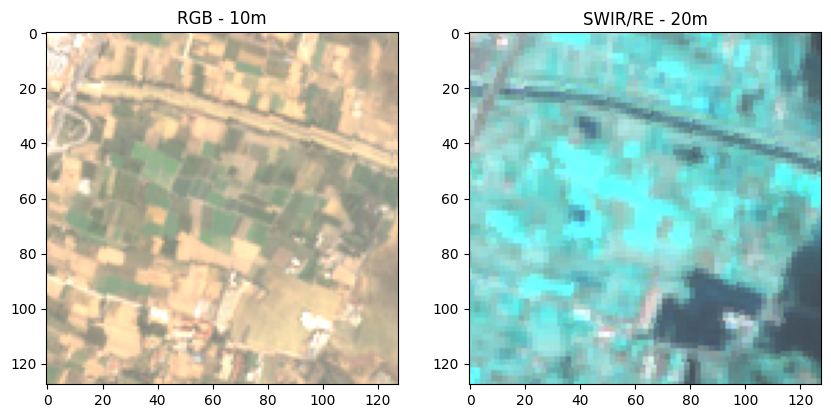

In [ ]:
# Have a look at LR image - RGB and 20m bands
plot_lr(low_resolution)

## Get Model and run SR

#### Download model

In [ ]:
# Downloading files and Weights - ca 1.45GB
mlstac.download(
  file="https://huggingface.co/tacofoundation/RS-SR-LTDF/resolve/main/main/mlm.json",
  output_dir="model/LDSRS2-SEN2SR/")

ModelLoader(file='/content/model/LDSRS2-SEN2SR/mlm.json', scheme='local')

In [ ]:
# Instanciate the compiled model
model = mlstac.load("model/LDSRS2-SEN2SR/").compiled_model(device=device)
model = model.to(device)
model.sr_model.sr_model.model.linear_end

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.63 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 128, 128) = 65536 dimensions.
making attention of type 'vanilla' with 512 in_channels
Normalization disabled.


0.0155

### Run Super-Resolution

In [ ]:
# Run on 128x128 patch
if edge_size == 128:
  # Performing SR - LDSR-S2 on RGB-NIR, SEN2SR-SWIN on 20m bands
  # input needs to be Bx10x128x128
  super_resolution = model(low_resolution.unsqueeze(0)).squeeze(0)

In [ ]:
if edge_size > 128:
  super_resolution = sen2sr.predict_large(
      model=model,
      X=low_resolution, # LR input tensor
      overlap=16, # Overlap between Patches
  )

### Inspect Results

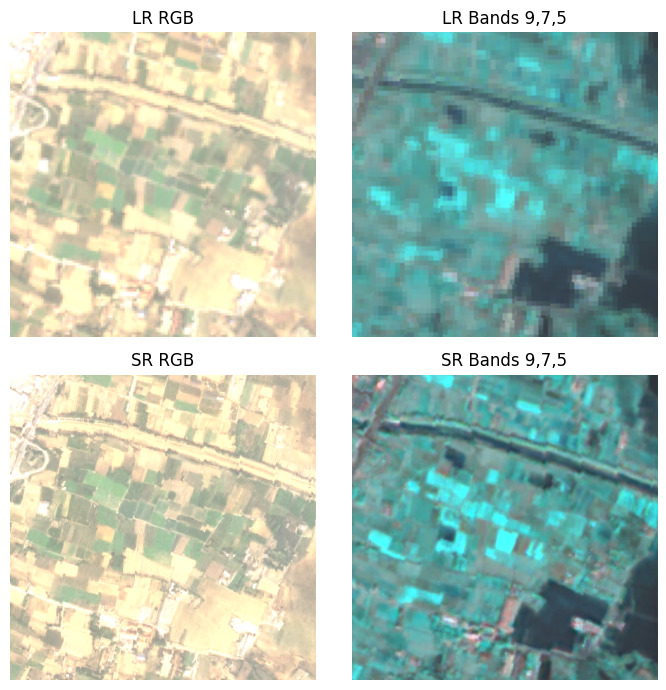

In [ ]:
# PLot and compare LR - SR
plot_lr_sr(low_resolution,super_resolution)

## Export and Save Results

In [ ]:
# Save both Input and Output as georeferenced GeoTIFs
save_tensor_as_geotiff(low_resolution, da[IMAGE_INDEX].attrs, out_path="lr.tif", super_resolved=False)
save_tensor_as_geotiff(super_resolution, da[IMAGE_INDEX].attrs, out_path="sr.tif", super_resolved=True)